# Telecom Churn Case Study - Decision Tree Based Boosting Modelling
#### Predict churning customers for a Telecom company based on temporal behavior.

## 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this case study, our goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

**Our Approach**

We will follow the below steps while executing this case study:

1. Import & Understand Data
2. Clean & Transform Data
3. Perform Exploratory Data Analysis
4. Perform Feature Engineering
5. Preprare Data for Modeling
6. Build and Evaluate Models
7. Select Model and Make Predictions
8. Conclusion

## 1. Import & Understand Data

In [293]:
# import packages

import numpy as np, pandas as pd
import re

import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import PartialDependenceDisplay

### 1.1 Load Train and Test (Unseen) Dataset

We first load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, we will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [214]:
df_train = pd.read_csv('train.csv')
df_unseen = pd.read_csv('test.csv')
print(f'Train dataset : {0}', df_train.shape)
print(f'Test dataset : {0}', df_unseen.shape)

Train dataset : 0 (69999, 172)
Test dataset : 0 (30000, 171)


In [215]:
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [216]:
# Verifying the train and test data set having same columns of same type.

df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [217]:
df_unseen.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

### 1.2 Understand Data Dictionary

In [218]:
# Read the data dictionary
data_dict = pd.read_csv("data_dictionary.csv")
pd.set_option('max_colwidth', None)
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [219]:
pd.reset_option('max_colwidth')

### 1.3 Drop Non-useful Attributes

The approach we use here is to understand each Acronym, figure out what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if we want the total minutes a person has spent on outgoing calls, we need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [220]:
# Let's review all the columns which deal with local outgoing (loc_og) calls
feature_cols = [i for i in list(df_train.columns) if re.search('loc_og_.',i)]
#total_og_mou = [i for i in list(df_train.columns) if re.search('(?<!in_)total.+og.+mou',i)]
df_train[feature_cols].head()

,loc_og_t2o_mou,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8
0,0.0,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00
2,0.0,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00
3,0.0,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63
4,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76


In [221]:
# Check if loc_og_mou columns contain the aggregated value of all other loc_og_* columns
feature_cols_1 = [i for i in list(df_train.columns) if re.search('loc_og_(?!mou)',i)]  # Lists the loc_og component-wise columns
feature_cols_2 = [i for i in list(df_train.columns) if re.search('loc_og_(?=mou)',i)]  # Lists the loc_og_mou_* cols
(df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe()

count    67430.000000
mean         1.167844
std          7.414176
min          0.978261
25%          0.999903
50%          0.999989
75%          1.010456
max       1736.000000
dtype: float64

**Observation**: The above ratio varies within a narrow range around 1. Hence loc_og_mou_* columns contain aggregate values of component-wise outgoing call minutes of usage (MOU). So the component-wise outgoing call columns can be dropped as those don't provide any independent information i.e. those are not independent variables

In [222]:
# Let's store all those columns to be dropped in a single list
cols_to_drop = feature_cols_1

In [223]:
# Let's review all the columns which deal with local incoming (loc_ic) calls
feature_cols = [i for i in list(df_train.columns) if re.search('loc_ic_.',i)]
df_train[feature_cols].head()

,loc_ic_t2o_mou,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8
0,0.0,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71
1,0.0,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03
2,0.0,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01
3,0.0,24.98,4.84,23.88,53.99,44.23,57.14,7.23,0.81,0.00,86.21,49.89,81.03
4,0.0,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31


In [224]:
# Check if loc_ic_mou_* columns contain the aggregated value of all other loc_ic_* columns
feature_cols_1 = [i for i in list(df_train.columns) if re.search('loc_ic_(?!mou)',i)]  # Lists the loc_ic component-wise columns
feature_cols_2 = [i for i in list(df_train.columns) if re.search('loc_ic_(?=mou)',i)]  # Lists the loc_ic_mou_* cols
(df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe()

count    68270.000000
mean         0.999860
std          0.000280
min          0.975000
25%          0.999845
50%          0.999925
75%          0.999965
max          1.000000
dtype: float64

**Observation**: The above ratio varies within a narrow range around 1. Hence loc_ic_mou_* columns contain aggregate values of component-wise incoming call MOUs. So the component-wise incoming call columns can be dropped as those are not independent variables

In [225]:
# Add these columns to the to-be-dropped list
cols_to_drop = cols_to_drop + feature_cols_1

In [226]:
# Similarly, let's review all the columns which deal with std outgoing (std_og) calls
feature_cols = [i for i in list(df_train.columns) if re.search('std_og.',i)]
df_train[feature_cols].head()

,std_og_t2o_mou,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8
0,0.0,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01
1,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,0.0,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00
3,0.0,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,0.0,0.0,0.0,16.16,37.99,4.60
4,0.0,0.00,0.00,0.00,4.35,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4.35,0.00,0.00


In [227]:
# Check if std_og_mou_* columns contain the aggregated value of all other std_og_* columns
feature_cols_1 = [i for i in list(df_train.columns) if re.search('std_og_(?!mou)',i)]  # Lists the std_og component-wise columns
feature_cols_2 = [i for i in list(df_train.columns) if re.search('std_og_(?=mou)',i)]  # Lists the std_og_mou_* cols
(df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe()

count    57625.000000
mean         0.999925
std          0.000369
min          0.966667
25%          0.999960
50%          0.999995
75%          1.000000
max          1.000000
dtype: float64

**Observation**: The above ratio varies within a narrow range around 1. Hence std_og_mou_* columns contain aggregate values of component-wise incoming call MOUs. So the component-wise outgoing call columns can be dropped as those are not independent variables

In [228]:
# Add these columns to the to-be-dropped list
cols_to_drop = cols_to_drop + feature_cols_1

In [229]:
# On similar lines, all std_ic_* columns can be dropped as those are aggregated by std_ic_mou_* columns
feature_cols_1 = [i for i in list(df_train.columns) if re.search('std_ic_(?!mou)',i)]  # Lists the std_ic component-wise columns
feature_cols_2 = [i for i in list(df_train.columns) if re.search('std_ic_(?=mou)',i)]  # Lists the std_ic_mou_* cols
print((df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe())
cols_to_drop = cols_to_drop + feature_cols_1

count    62094.000000
mean         0.999789
std          0.000777
min          0.923077
25%          0.999801
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64


In [230]:
# Now let's review if all local, std, roam and other outgoing MOUs are further aggregated under total_og_mou columns

feature_cols_1 = [i for i in list(df_train.columns) if re.search('(?<!total_)og_mou.',i)]  # Lists local, std, roam and other outgoing MOUs
feature_cols_1 += [i for i in list(df_train.columns) if re.search('og_others.',i)]
feature_cols_2 = [i for i in list(df_train.columns) if re.search('(?<=total_)og_mou.',i)]  # Lists total outgoing MOUs
print((df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe())
cols_to_drop = cols_to_drop + feature_cols_1

count    68133.000000
mean         1.532803
std         67.413202
min          0.944444
25%          0.999955
50%          0.999990
75%          1.007992
max      17423.000000
dtype: float64


In [231]:
# Similarly let's review if all local, std, roam and other incoming MOUs are further aggregated under total_ic_mou columns

feature_cols_1 = [i for i in list(df_train.columns) if re.search('(?<!total_)ic_mou.',i)]  # Lists local, std, roam and other incoming MOUs
feature_cols_1 += [i for i in list(df_train.columns) if re.search('ic_others.',i)]
feature_cols_2 = [i for i in list(df_train.columns) if re.search('(?<=total_)ic_mou.',i)]  # Lists total incoming MOUs
print((df_train[feature_cols_1].sum(axis=1)/ df_train[feature_cols_2].sum(axis=1).replace(0, np.nan)).describe())
cols_to_drop = cols_to_drop + feature_cols_1

count    68456.000000
mean         1.325283
std         17.791975
min          0.961538
25%          0.999942
50%          0.999985
75%          1.010112
max       4021.666667
dtype: float64


In [232]:
# Last date of month doesn't have any actionable information - those can be droped
feature_cols = [i for i in list(df_train.columns) if re.search('last_date_of_month.',i)]
cols_to_drop = cols_to_drop + feature_cols

In [233]:
# We now remove the columns to be dropped from df_train and df_unseen
df_train = df_train.drop(cols_to_drop, axis=1)
print('df_train shape: ', df_train.shape)
df_unseen = df_unseen.drop(cols_to_drop, axis=1)
print('df_unseen shape: ', df_unseen.shape)

df_train shape:  (69999, 85)
df_unseen shape:  (30000, 84)


In [234]:
# Check if the targeted columns have been dropped
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        69999 non-null  int64  
 1   circle_id                 69999 non-null  int64  
 2   arpu_6                    69999 non-null  float64
 3   arpu_7                    69999 non-null  float64
 4   arpu_8                    69999 non-null  float64
 5   onnet_mou_6               67231 non-null  float64
 6   onnet_mou_7               67312 non-null  float64
 7   onnet_mou_8               66296 non-null  float64
 8   offnet_mou_6              67231 non-null  float64
 9   offnet_mou_7              67312 non-null  float64
 10  offnet_mou_8              66296 non-null  float64
 11  total_og_mou_6            69999 non-null  float64
 12  total_og_mou_7            69999 non-null  float64
 13  total_og_mou_8            69999 non-null  float64
 14  total_

## 2. Clean & Transform Data

#### In this step will check the data and do the following actions
1. Drop columns with more than 60% missing values
2. Drop duplicate columns
3. Drop columns contain only one unique value as data
4. Check for outlier values and cap the outliers based on K-sigma
5. Convert the columns to appropriate type based on the data
6. Impute the missing values

In [235]:
# remove columns with more than 60% missing values
missing_values = df_train.isna().mean() * 100
columns = missing_values[missing_values > 60].index

print(f'Train data before dropping missing columns : ', df_train.shape)
print(f'Test data before dropping missing columns : ', df_unseen.shape)
df_train.drop(columns=columns, inplace=True)
df_unseen.drop(columns=columns, inplace=True)
print(f'Train data after dropping missing columns : ', df_train.shape)
print(f'Test data after dropping missing columns : ', df_unseen.shape)

Train data before dropping missing columns :  (69999, 85)
Test data before dropping missing columns :  (30000, 84)
Train data after dropping missing columns :  (69999, 55)
Test data after dropping missing columns :  (30000, 54)


In [236]:
#Drop duplicate records

print(f'Train data before dropping duplicate records : ', df_train.shape)
print(f'Test data before dropping duplicate records : ', df_unseen.shape)
df_train.drop_duplicates()
df_unseen.drop_duplicates()
print(f'Train data after dropping duplicate records : ', df_train.shape)
print(f'Test data after dropping duplicate records: ', df_unseen.shape)

Train data before dropping duplicate records :  (69999, 55)
Test data before dropping duplicate records :  (30000, 54)
Train data after dropping duplicate records :  (69999, 55)
Test data after dropping duplicate records:  (30000, 54)


In [237]:
#remove dataset columns with one unique value

print(f'Train data before dropping 1 unique value column : ', df_train.shape)
print(f'Test data before dropping 1 unique value column : ', df_unseen.shape)
columns_with_one_unique_value = [col for col in df_train.columns if df_train[col].nunique() == 1]

df_train.drop(columns=columns_with_one_unique_value, inplace=True)
df_unseen.drop(columns=columns_with_one_unique_value, inplace=True)

print(f'Train data after dropping 1 unique value column : ', df_train.shape)
print(f'Test data after dropping 1 unique value column : ', df_unseen.shape)

Train data before dropping 1 unique value column :  (69999, 55)
Test data before dropping 1 unique value column :  (30000, 54)
Train data after dropping 1 unique value column :  (69999, 54)
Test data after dropping 1 unique value column :  (30000, 53)


In [238]:
# set index of dataframes to 'id'
df_train.set_index('id', inplace=True)
df_unseen.set_index('id', inplace=True)

In [239]:
#checking outlier values and removing it based on k-sigma
df_train.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,total_og_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,306.451436,...,0.077730,0.081958,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887
std,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,465.502866,...,0.383189,0.381821,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502
min,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,44.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,145.280000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,374.305000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
90%,619.993800,615.661400,614.994600,345.080000,347.908000,343.695000,482.030000,482.071000,486.980000,785.230000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2792.000000,160.444000,136.272000,110.32800,1.000000
95%,832.022700,823.236700,828.464700,617.185000,628.437500,620.240000,735.985000,747.558000,738.017500,1171.188000,...,1.000000,1.000000,0.000000,0.000000,0.000000,3108.000000,464.277000,446.353000,400.13400,1.000000
99%,1400.276640,1414.891380,1445.054800,1447.098000,1478.540900,1472.480500,1546.471000,1545.104000,1522.474000,2235.611000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3651.000000,1226.659800,1254.279000,1188.26780,1.000000


In [240]:
# Define a function to reset outliers values for numeric columns to upper or lower caps

def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [241]:
# Find the columns with numeric values to reset outlier data

num_cols = df_train.select_dtypes(include=['number']).columns
num_col_list = num_cols.tolist()
num_col_list.remove('churn_probability')

# Reset outliers for df_train
df_train[num_col_list] = df_train[num_col_list].apply(cap_outliers)

# Reset outliers for df_unseen
df_unseen[num_col_list] = df_unseen[num_col_list].apply(cap_outliers)

In [242]:
#converting date columns to datetime datatype
date_cols = df_train.select_dtypes(include='object').columns
print('Object columns : ', date_cols)


# Apply the date conversion function column-wise using apply() 
for col in date_cols:
    df_train[col] = pd.to_datetime(df_train[col], format='%m/%d/%Y')
    df_unseen[col] = pd.to_datetime(df_unseen[col], format='%m/%d/%Y')


Object columns :  Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')


In [243]:
# Impute missing data for numeric and non-numeric columns

def impute_num_data(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    imp = SimpleImputer(strategy='constant', fill_value=0)
    missing_data_percent = df[num_cols].isnull().any()
    num_impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
    if len(num_impute_cols) > 0:
        df[num_impute_cols] = imp.fit_transform(df[num_impute_cols])


def impute_non_num_data(df):
    non_num_cols = df.select_dtypes(exclude=[np.number]).columns
    missing_data_percent = df[non_num_cols].isnull().any()
    num_impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
    for col in num_impute_cols:
        mode_val = df[col].mode(dropna=True)
        if not mode_val.empty:  # Check if mode exists
            # Fill missing values with the mode (first mode if multiple)
            df[col].fillna(mode_val[0], inplace=True)

impute_num_data(df_train)
impute_num_data(df_unseen)


impute_non_num_data(df_train)
impute_non_num_data(df_unseen)

## 3. Perform Exploratory Data Analysis

### 3.1 Build Visualisation Utility Functions

In [244]:
# Define a function to visualize influence of numeric variables on target variable
def bva_num_tgt_vars (df, num_cols, yaxis_labels, target_var, xaxis_label):
    rows = len(num_cols)//3 + min(len(num_cols) % 3, 1)
    fix, ax = plt.subplots(nrows=rows, ncols=3, figsize=(12,rows*4))
    # color_dict = {0:'salmon', 1:'lightgreen', 2:'lightblue', 3:'thistle', 4:'beige'}
    graph_cnt = 0
    for i in num_cols:
        if rows == 1: axis = ax[ graph_cnt % 3]
        else: axis = ax[ graph_cnt // 3, graph_cnt % 3]
        
        sns.boxplot(data=df, x=target_var, y=i, ax=axis, hue=target_var, palette=['tab:green','tab:orange'], 
                    legend=True if (graph_cnt % 3 == 2) else False)

        axis.set_title(yaxis_labels[graph_cnt], size = 12, color='blue')
        axis.tick_params(labelsize = 8, labelrotation = 0)
        axis.set_xlabel(xaxis_label, size = 10, color='brown')
        # axis.set_ylabel(yaxis_labels[graph_cnt], size = 12, color='brown')
        axis.set_ylabel("")
        # Add legend for the right-side graph
        if graph_cnt % 3 == 2:
            axis.legend(labels = ["Not Churned", "Churned"],
                  fontsize = 8,
                  title = xaxis_label,
                  title_fontsize = 8,
                  # bbox_transform=axis.transAxes,
                  bbox_to_anchor = [1, 1]
            )
        
        graph_cnt += 1
    plt.show()

In [245]:
# Define a function to create boxplot between target and a single numeric variable after removing outliers
def bva_nofliers_num_var (df, y_var, yaxis_label, x_var, xaxis_label):

    fix, ax = plt.subplots(figsize=(8,4))

    Q1 = df[y_var].quantile(0.25)
    Q3 = df[y_var].quantile(0.75)
    IQR = Q3 - Q1 
    
    filter = (df[y_var] >= Q1 - 1.5 * IQR) & (df[y_var] <= Q3 + 1.5 *IQR)
    df = df.loc[filter]
    
    sns.boxplot(data=df, x=x_var, y=y_var, ax=ax, hue=x_var, palette=['tab:green','tab:orange'], )

    # Adding title, tick and axes labels
    ax.set_title(xaxis_label + " vs. " + yaxis_label, size = 14, color='blue')
    ax.tick_params(labelsize = 10, labelrotation = 0)
    ax.set_xlabel(xaxis_label, size = 12, color='brown')
    ax.set_ylabel(yaxis_label, size = 12, color='brown')

    # Adding legend
    ax.legend(labels = ["Not Churned", "Churned"],
                  fontsize = 10,
                  title = xaxis_label,
                  title_fontsize = 10,
                  bbox_transform=ax.transAxes,
                  bbox_to_anchor = [1.25, 1]
            )
    
    plt.show()

### 3.2  Perform Bi-variate Analysis

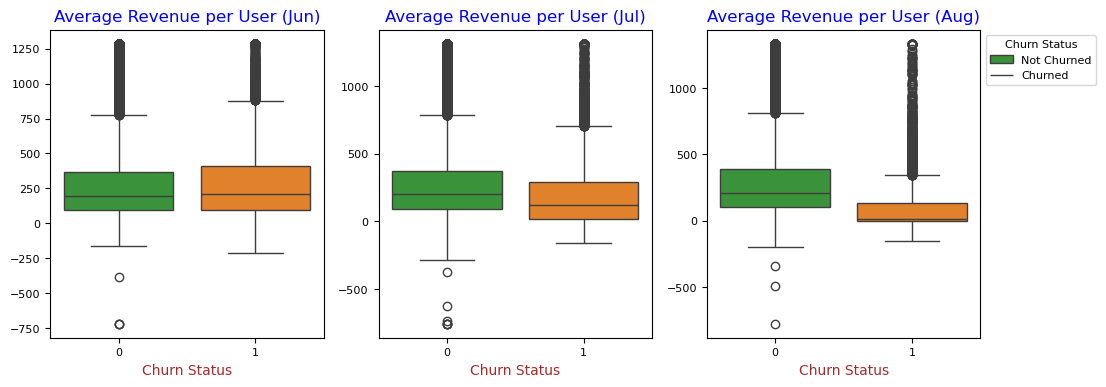

In [246]:
# Create the graphs with x-axis as target variable (churn_probability) and y-axis as ARPU

num_vars = [i for i in list(df_train.columns) if re.search('arpu_(?!g)',i)]
num_labels = ['Average Revenue per User (Jun)', 'Average Revenue per User (Jul)', 'Average Revenue per User (Aug)']
bva_num_tgt_vars (df_train, num_vars, num_labels, 'churn_probability', 'Churn Status')

**Observations:** ARPU has been steady for non-churning customers while it reduced significantly in July and Aug months for churning customers. ARPU thus acts as a leading indicator of customer churn

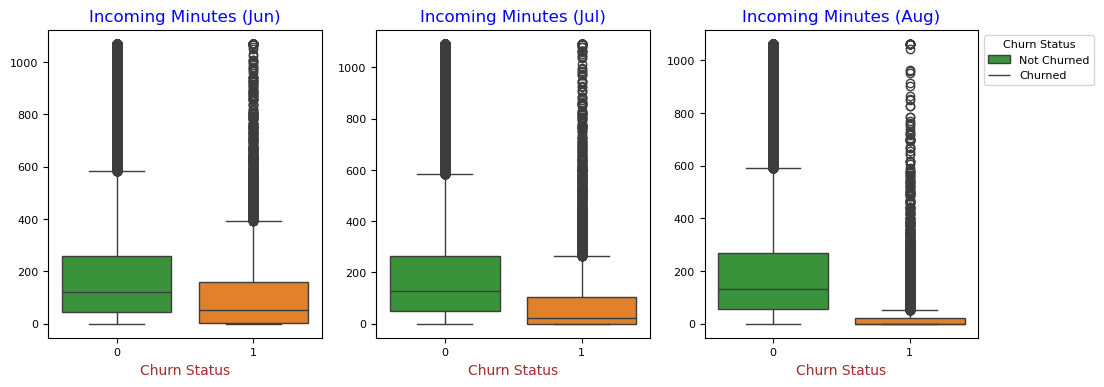

In [247]:
# Create the graphs with x-axis as target variable (churn_probability) and y-axis as total_ic_mou

num_vars = [i for i in list(df_train.columns) if re.search('total.+ic.+mou',i)]
num_labels = ['Incoming Minutes (Jun)', 'Incoming Minutes (Jul)', 'Incoming Minutes (Aug)']
bva_num_tgt_vars (df_train, num_vars, num_labels, 'churn_probability', 'Churn Status')

**Observations:** The volume of incoming calls has been steady for non-churning customers while it is consistently lower for churning customers with progressively reducing trend. Incoming Calls volume thus acts as a leading indicator of customer churn

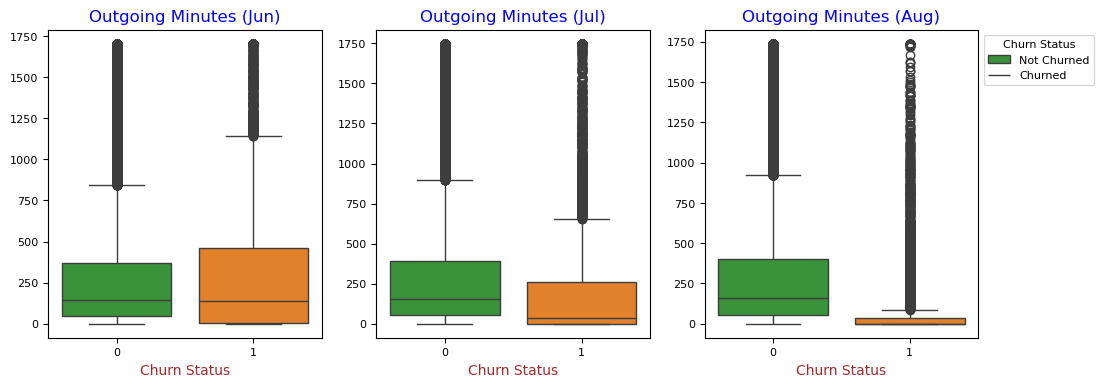

In [248]:
# Create the graphs with x-axis as target variable (churn_probability) and y-axis as total_og_mou

num_vars = [i for i in list(df_train.columns) if re.search('total.+og.+mou',i)]
num_labels = ['Outgoing Minutes (Jun)', 'Outgoing Minutes (Jul)', 'Outgoing Minutes (Aug)']
bva_num_tgt_vars (df_train, num_vars, num_labels, 'churn_probability', 'Churn Status')

**Observations:** Outgoing calls usage has been steady for non-churning customers while it reduced significantly in July and Aug months for churning customers. Hence sudden reducing call volume may be an indicator for customer churn

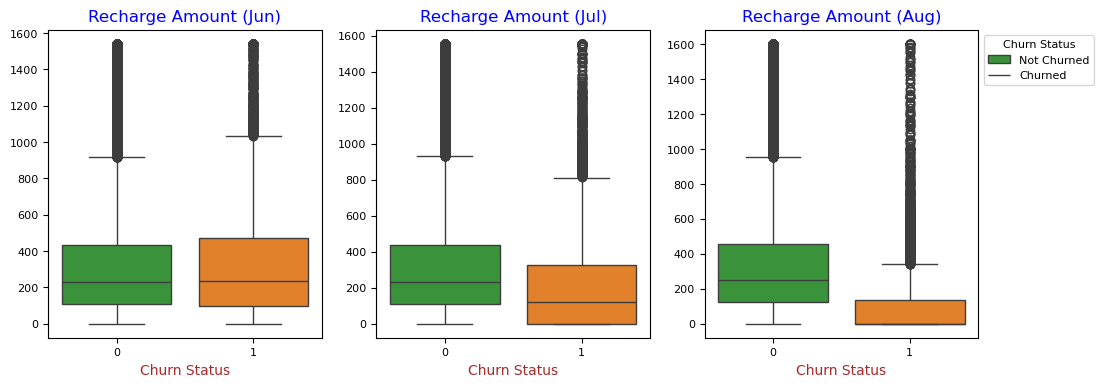

In [249]:
# Create the graphs with x-axis as target variable (churn_probability) and y-axis as total_rech_amt

num_vars = [i for i in list(df_train.columns) if re.search('total.+rech.+amt',i)]
num_labels = ['Recharge Amount (Jun)', 'Recharge Amount (Jul)', 'Recharge Amount (Aug)']
bva_num_tgt_vars (df_train, num_vars, num_labels, 'churn_probability', 'Churn Status')

**Observations:** Recharge amount for churning customers reduce gradually thus acting as a leading indicator of customer churn

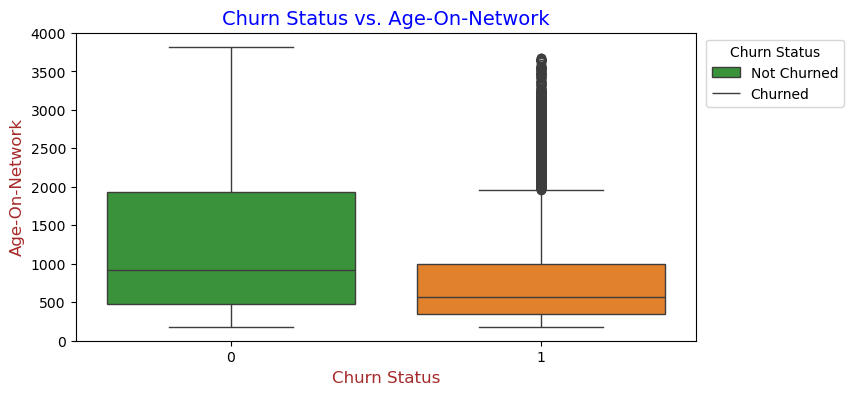

In [250]:
# Draw the churn_probability vs. aon graph after removing outliers

bva_nofliers_num_var (df_train, 'aon', 'Age-On-Network', 'churn_probability', 'Churn Status')

**Observations:** It looks like once a customer stays on with the service provider for 1000 days, then they are likely to become a loyal customer.

### 3.3 Distribution of churn_probability 

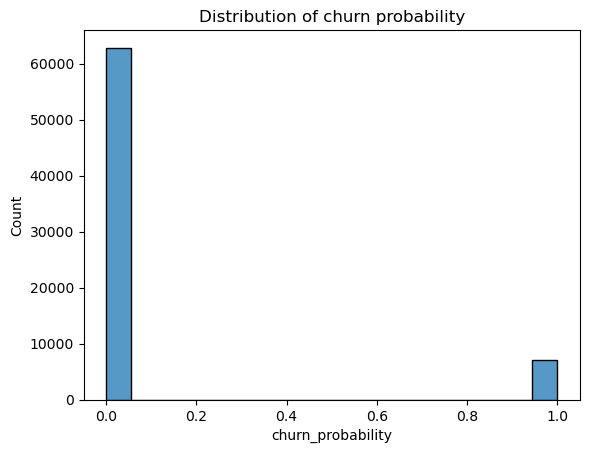

In [300]:

plt.title('Distribution of churn probability')
sns.histplot(df_train['churn_probability'])
plt.show()

In [252]:
## ABove histogram clearly shows a data imbalace, for model building it will be addressed seperatly

### 3.4 Analysis of aon and churn_probability 

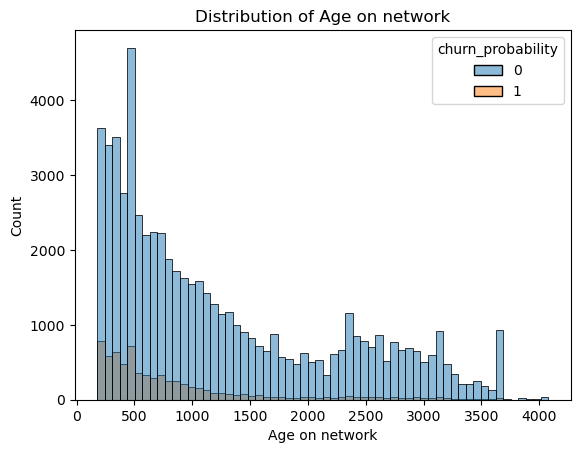

In [253]:
sns.histplot(data=df_train, x='aon', hue='churn_probability')
plt.title('Distribution of Age on network')
plt.xlabel('Age on network')
plt.show()

In [254]:
# Graph clearly shows churn rate is high for users who are newly joined ie churn rate for  
# users who are using the network for long is very trivial

### 3.5 Analysis Days since last recharge and churn probability

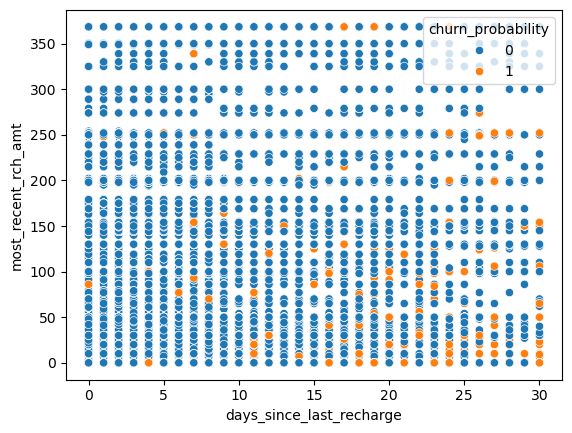

In [255]:
def find_days_since_last_rechrge(df):
    # Set the last day of August
    last_day_of_august = pd.to_datetime('2014-08-31')

    # Find the most recent recharge date for each row
    date_recharge_cols = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
    amnt_recharge_cols = ['last_day_rch_amt_8', 'last_day_rch_amt_7', 'last_day_rch_amt_6']
    most_recent_recharge = df[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)

    # Find the most recent recharge date for each row and calculate the days since the last recharge
    df['days_since_last_recharge'] = df[date_recharge_cols].max(axis=1).apply(
        lambda x: (last_day_of_august - x).days if pd.notnull(x) else 0
    )
    
    df['most_recent_rch_amt'] = df[amnt_recharge_cols].bfill(axis=1).iloc[:, 0]
    df.drop(columns=[*amnt_recharge_cols, *date_recharge_cols], inplace=True)
    
    
find_days_since_last_rechrge(df_train)
find_days_since_last_rechrge(df_unseen)

#drop last_day_rch_amt_* and date_of_last_rech_*


sns.scatterplot(data=df_train, x='days_since_last_recharge' , y='most_recent_rch_amt', hue='churn_probability')
plt.show()

In [256]:
# days_since_last_recharge and most_recent_rch_amt clearly showing a trend

### 3.6 Analysis of Age on network and Average Revenue per user

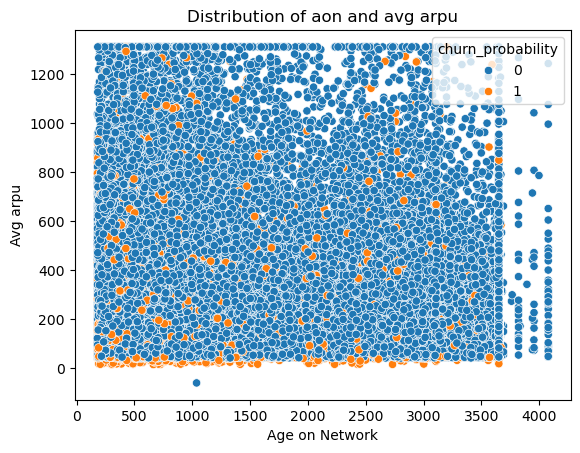

In [257]:
# Scatter chart will show the distribution of the various clusters of users such that the customers can be seggregated to high value customer or not
mnthly_arpu_cols  = [i for i in list(df_train.columns) if re.search('arpu_[6-8]$',i)]
avg_arpu = df_train[mnthly_arpu_cols].mean(axis=1)
plt.title('Distribution of aon and avg arpu')
plt.xlabel('Age on Network')
plt.ylabel('Avg arpu')
sns.scatterplot(x=df_train.aon, y=avg_arpu, hue=df_train['churn_probability'])
plt.show()

In [258]:
#In the above graph churn rate is high for low arpu and aon for avg arpu of < 150 churn rate is extreme 

### 3.7 Analysis of Correlation Heatmap

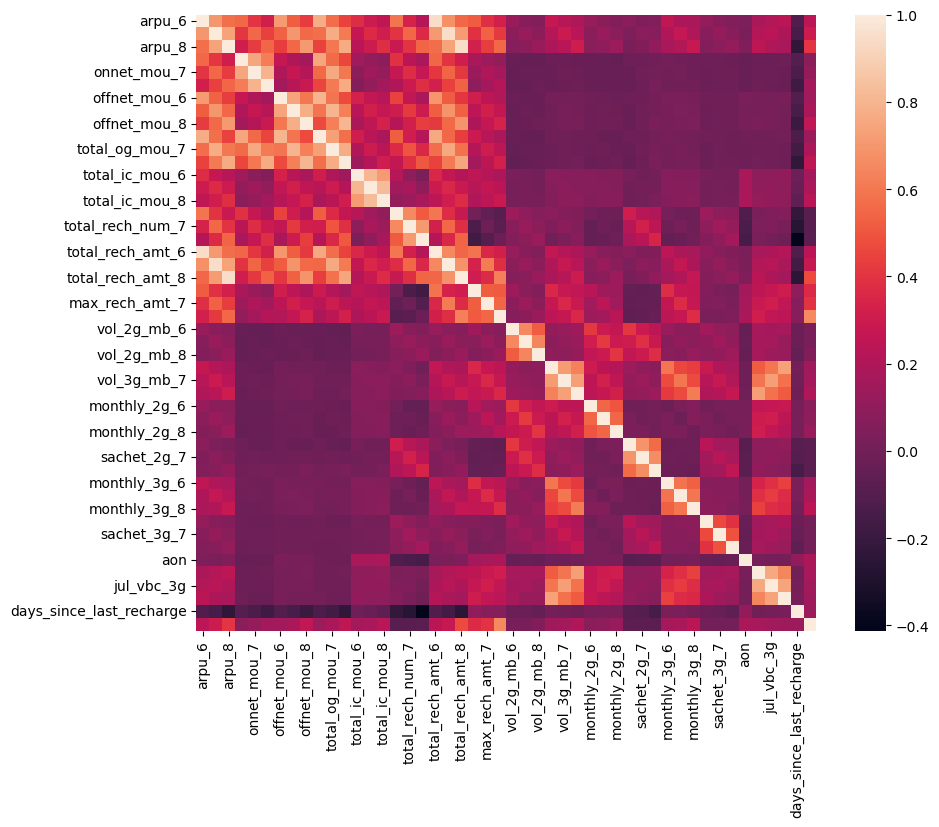

In [259]:
plt.figure(figsize=(10,8))

numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()


column_to_exclude = 'churn_probability'  
numeric_cols = [col for col in numeric_cols if col != column_to_exclude]
sns.heatmap(df_train[numeric_cols].corr())
plt.show()

**Observations:** Heat map shows multiples values being correlated with each other. These need to be addressed while doing feature selection

## 4. Perform Feature Engineering

### 4.1 Analysis of Trend in Critical Revenue and Usage Parameters

In [260]:
# Since arpu and other revenue & usage parameters are give for 3 months, compute trend in these 3 months 
# Trends as another feature may have impact on churn probability


def find_value_std(df, regx, newcol):
    total_outgoing_minutes_cols = [i for i in list(df_train.columns) if re.search(regx ,i)]
    df[newcol] = df_train[total_outgoing_minutes_cols].std(axis = 1)
    df[newcol].fillna(0, inplace=True)
#     df.drop(columns=total_outgoing_minutes_cols, inplace=True)

def change_in_percentage(df, col_prefix):
    
    col_names = [col_prefix+'_6', col_prefix+'_7', col_prefix+'_8']
    prev_month = df.apply(
         lambda x: ((x[f'{col_prefix}_7'] - x[f'{col_prefix}_6']) / x[f'{col_prefix}_6']) * 100 
              if x[f'{col_prefix}_6'] != 0 else 0, axis=1)
    latest_month = df.apply(
        lambda x: ((x[f'{col_prefix}_8'] - x[f'{col_prefix}_7']) / x[f'{col_prefix}_7']) * 100 
              if x[f'{col_prefix}_7'] != 0 else 0, axis=1)
        
    df[f'avg_perc_change_in_{col_prefix}'] = (prev_month +  latest_month)/2
    df[f'avg_perc_change_in_{col_prefix}'].fillna(0, inplace=True)
    #drop the columns used to derived the new feature
#     df.drop(columns=col_names, inplace=True)



def change_in_value_n_std(df_train, df_test):

    # Find arpu derived columns
    
    # change in arpu 
    mnthly_arpu_cols  = [i for i in list(df_train.columns) if re.search('arpu_[6-8]$',i)]
    change_in_percentage(df_train, 'arpu')
    change_in_percentage(df_test, 'arpu')
    

     # Change in outgoing calls minutes

   
    find_value_std(df_train, 'total.+og.+mou', 'og_mou_std')
    find_value_std(df_test, 'total.+og.+mou', 'og_mou_std')
    
    find_value_std(df_train, 'total_ic_mou_[6-8]$', 'ic_mou_std')
    find_value_std(df_test, 'total_ic_mou_[6-8]$', 'ic_mou_std')

    
    
    # Change in recharge amount 
    mnthly_recharge_amt_cols = [i for i in list(df_train.columns) if re.search('total_rech_amt_[6-8]$',i)]
    change_in_percentage(df_train, 'total_rech_amt')
    change_in_percentage(df_test, 'total_rech_amt')
       

    
    # 3g data volumn
    mnthly_3g_data_cols = [i for i in list(df_train.columns) if re.search('vol.+3g',i)]
    change_in_percentage(df_train, 'vol_3g_mb')
    change_in_percentage(df_test, 'vol_3g_mb')
    
    
    mnthly_2g_data_cols = [i for i in list(df_train.columns) if re.search('vol.+2g',i)]
    change_in_percentage(df_train, 'vol_2g_mb')
    change_in_percentage(df_test, 'vol_2g_mb')
       

        

change_in_value_n_std(df_train, df_unseen)


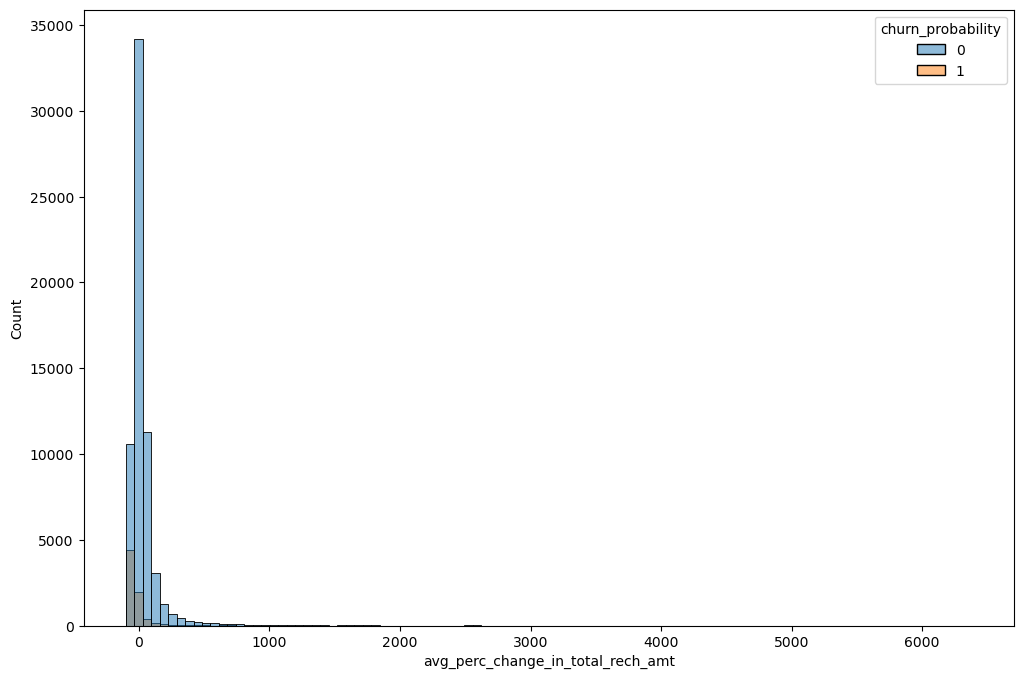

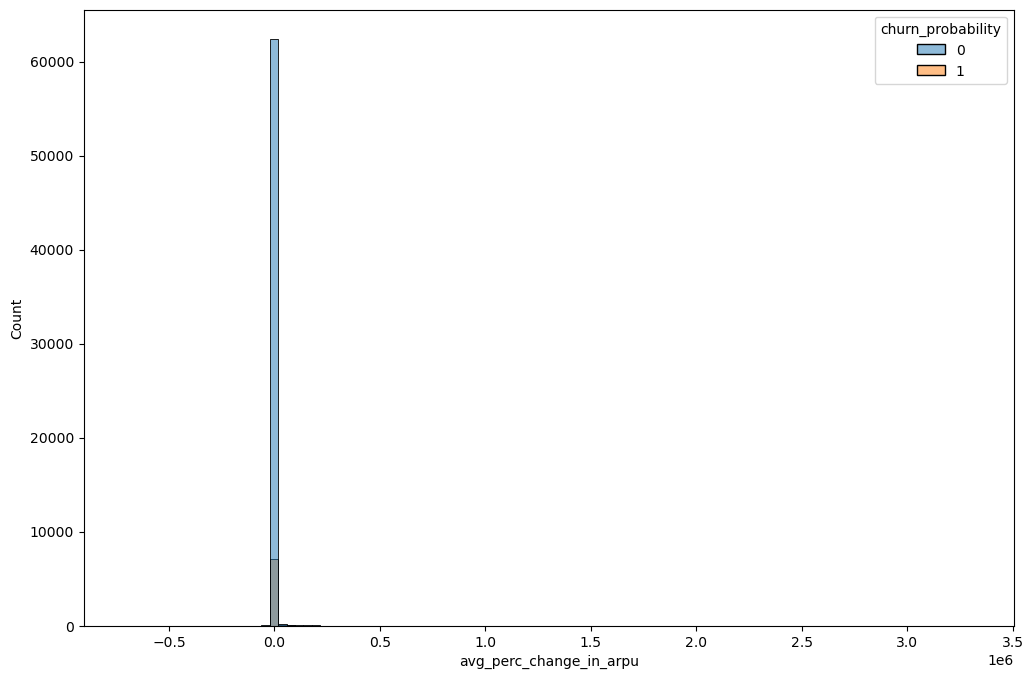

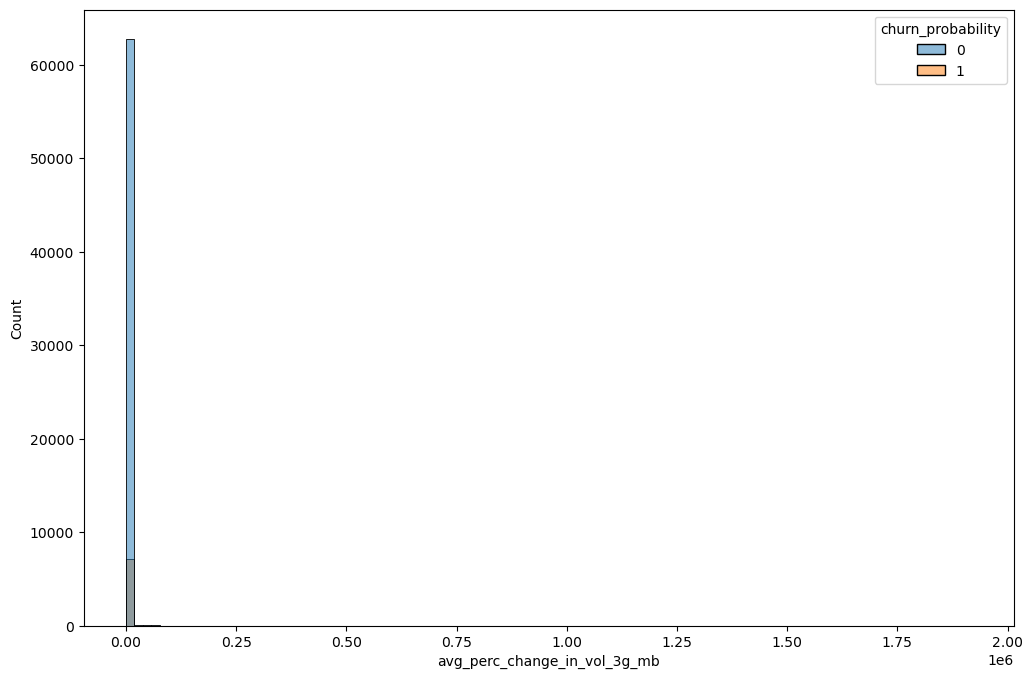

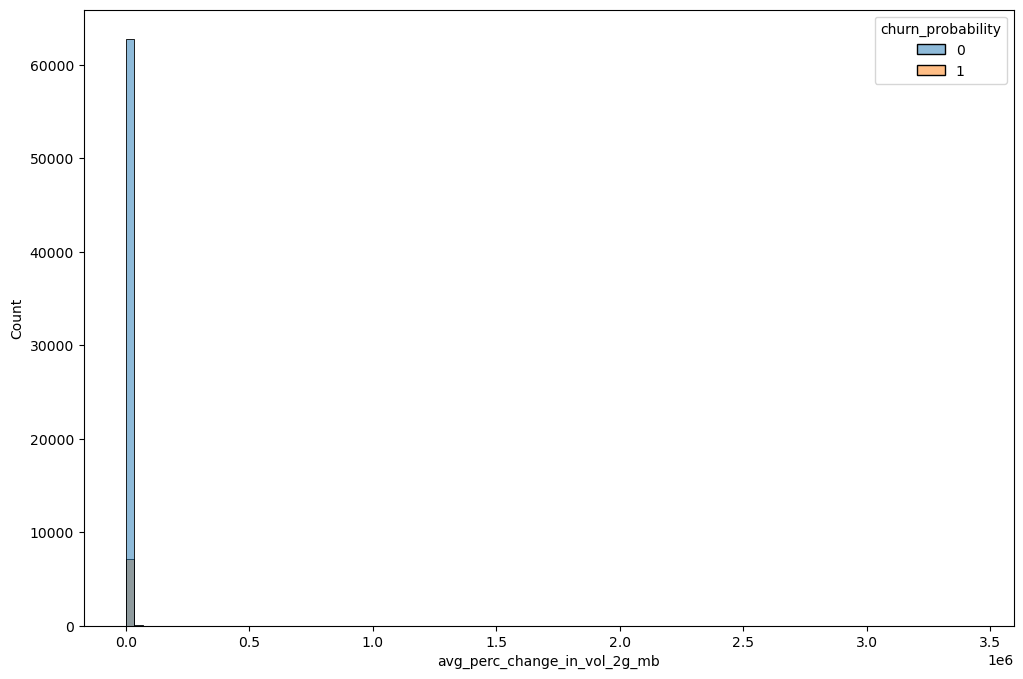

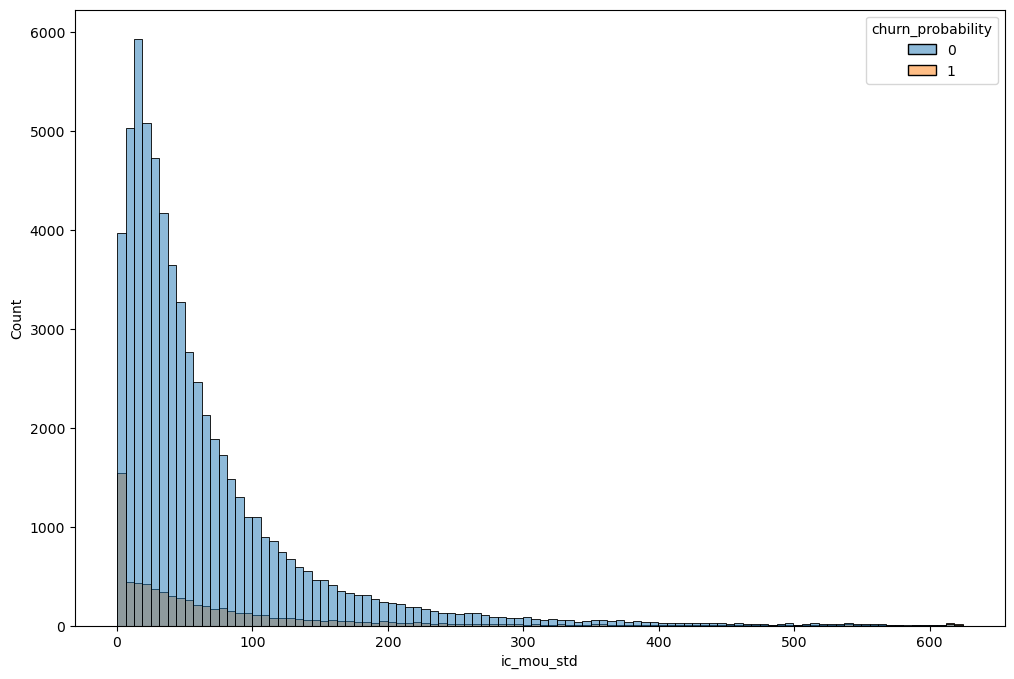

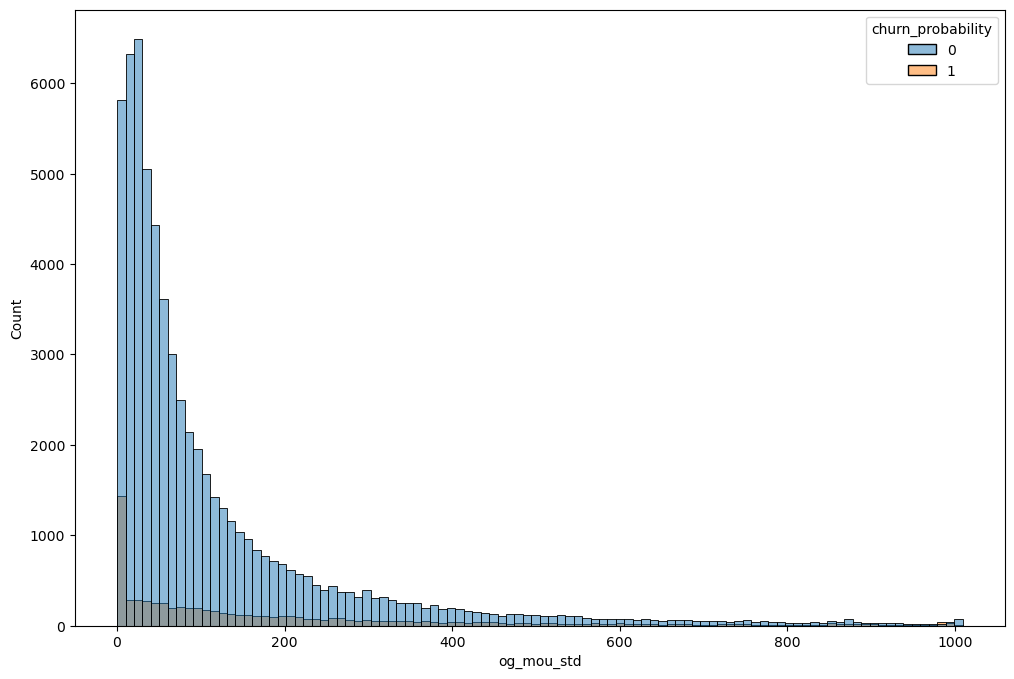

In [261]:
# plot the change in value and standard deviation to analys the pattern
cols_to_plot_perc_change_value = [
                                'avg_perc_change_in_total_rech_amt',                   
                                  'avg_perc_change_in_arpu',
                                 'avg_perc_change_in_vol_3g_mb',
                                 'avg_perc_change_in_vol_2g_mb']

cols_to_plot_std_ = ['ic_mou_std', 'og_mou_std']


for col in cols_to_plot_perc_change_value:
    plt.figure(figsize=(12,8))
    sns.histplot(data=df_train, x=col, hue='churn_probability', bins=100)
    plt.show()
    
for col_name in cols_to_plot_std_:
    plt.figure(figsize=(12,8))
    sns.histplot(data=df_train, x=col_name, hue='churn_probability', bins=100)
    plt.show()


#### Observations
 In the previous graphs the change in percentage values clearly show the -ve bars indicate high rate of churn
 

### 4.3 Analysis of the Ratio of Total Incoming and Outgoing MOUs

In [262]:
# Compute the ratio of incoming and outgoing MOUs
total_ic_mou = [i for i in list(df_train.columns) if re.search('total.+ic.+mou',i)]
total_og_mou = [i for i in list(df_train.columns) if re.search('(?<!in_)total.+og.+mou',i)]
df_train['ic_og_ratio'] = df_train[total_ic_mou].sum(axis=1)/ df_train[total_og_mou].sum(axis=1).replace(0, np.nan)
df_train['ic_og_ratio'].fillna(0, inplace=True)
df_train['ic_og_ratio'].head()

id
0    0.343991
1    1.088636
2    1.249663
3    1.014523
4    0.485487
Name: ic_og_ratio, dtype: float64

In [263]:
# Create the ratio of incoming and outgoing MOUs column for unseen dataset
df_unseen['ic_og_ratio'] = df_unseen[total_ic_mou].sum(axis=1)/ df_unseen[total_og_mou].sum(axis=1).replace(0, np.nan)
df_unseen['ic_og_ratio'].fillna(0, inplace=True)
df_unseen['ic_og_ratio'].head()

id
69999    0.600929
70000    0.563478
70001    0.000000
70002    5.884144
70003    0.170174
Name: ic_og_ratio, dtype: float64

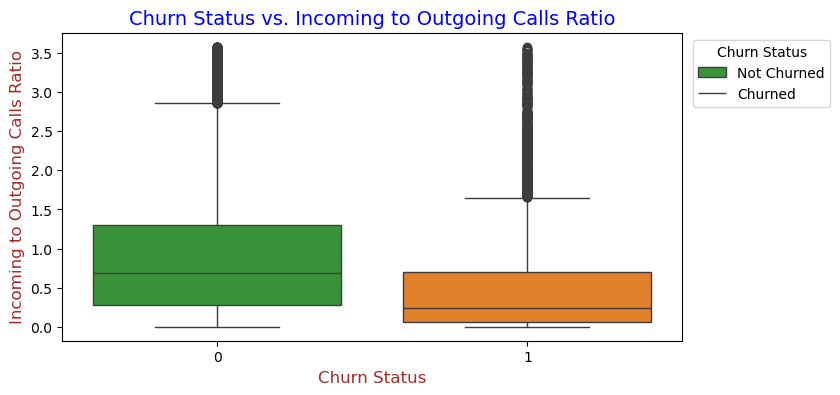

In [303]:
# Draw the churn_probability vs. ic_og_ratio graph after removing outliers

bva_nofliers_num_var (df_train, 'ic_og_ratio', 'Incoming to Outgoing Calls Ratio', 'churn_probability', 'Churn Status')

**Observations:** Typically the incoming to outgoing calls ratio is lower for churning customers. Hence any fall in this ratio should be reviewed seriously by service provider

### 4.4 Analysis of the Recharge Cost per Outgoing MOU

In [265]:
# Compute the recharge amount per outgoing MOU
total_rech_amt = [i for i in list(df_train.columns) if re.search('total_rech_amt.',i)]
total_og_mou = [i for i in list(df_train.columns) if re.search('(?<!in_)total.+og.+mou',i)]
df_train['amt_per_og_mou'] = df_train[total_rech_amt].sum(axis=1)/ df_train[total_og_mou].sum(axis=1).replace(0, np.nan)
df_train['amt_per_og_mou'].fillna(0, inplace=True)
df_train['amt_per_og_mou'].head()

id
0    0.495889
1    3.125501
2    1.219121
3    2.346690
4    4.493276
Name: amt_per_og_mou, dtype: float64

In [266]:
# Create the recharge amount per outgoing MOU column for unseen dataset
df_unseen['amt_per_og_mou'] = df_unseen[total_rech_amt].sum(axis=1)/ df_unseen[total_og_mou].sum(axis=1).replace(0, np.nan)
df_unseen['amt_per_og_mou'].fillna(0, inplace=True)
df_unseen['amt_per_og_mou'].head()

id
69999    1.250803
70000    0.921087
70001    0.000000
70002    1.337914
70003    0.720180
Name: amt_per_og_mou, dtype: float64

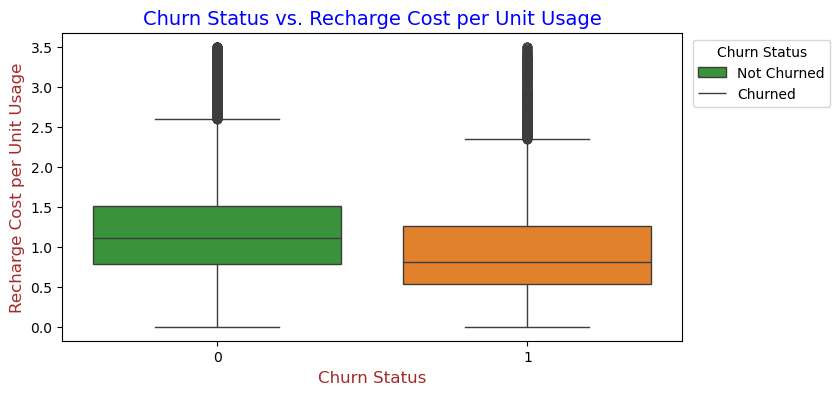

In [267]:
# Draw the churn_probability vs. amt_per_og_mou graph after removing outliers

bva_nofliers_num_var (df_train, 'amt_per_og_mou', 'Recharge Cost per Unit Usage', 'churn_probability', 'Churn Status')

**Observations:** Recharge cost per unit usage for churning customer is low. Hence this may not have any impact on decision process of a churning customer.

## 5. Preprare Data for Modeling

### 5.1 Split Train-Test Datasets

In [268]:
# Split the predictor and independent variables

y = df_train['churn_probability']
X = df_train.drop('churn_probability', axis=1)

print(X.shape, ' : ', y.shape)

(69999, 56)  :  (69999,)


In [269]:
# Create test dataset from the training data to measure the accuracy of the model

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.7)

print('Train dataset : ', X_train.shape, ' : ', y_train.shape)
print('Test dataset : ', X_test.shape, ' : ', y_test.shape)

X_train.info()

Train dataset :  (48999, 56)  :  (48999,)
Test dataset :  (21000, 56)  :  (21000,)
<class 'pandas.core.frame.DataFrame'>
Index: 48999 entries, 61787 to 15795
Data columns (total 56 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   arpu_6                             48999 non-null  float64
 1   arpu_7                             48999 non-null  float64
 2   arpu_8                             48999 non-null  float64
 3   onnet_mou_6                        48999 non-null  float64
 4   onnet_mou_7                        48999 non-null  float64
 5   onnet_mou_8                        48999 non-null  float64
 6   offnet_mou_6                       48999 non-null  float64
 7   offnet_mou_7                       48999 non-null  float64
 8   offnet_mou_8                       48999 non-null  float64
 9   total_og_mou_6                     48999 non-null  float64
 10  total_og_mou_7                     4

### 5.2 Scale the Datasets

In [270]:
scaler = StandardScaler()


#creating copy of data to keep the scaled values
X_train_scaled = X_train.copy()
df_unseen_scaled = df_unseen.copy()

num_cols_train = X_train_scaled.select_dtypes(include=[np.number]).columns

print(X_train_scaled.shape)
print(df_unseen_scaled.shape)

X_train[num_cols_train] = scaler.fit_transform(X_train_scaled[num_cols_train])

X_test[num_cols_train] = scaler.transform(X_test[num_cols_train])
df_unseen_scaled[num_cols_train] = scaler.transform(df_unseen_scaled[num_cols_train])

(48999, 56)
(30000, 56)


### 5.3 Balance Training Dataset

In [271]:
# Apply SMOTE to the training data to address imbalance of actual churn data (positive cases)
# The SMOTEd data may be required for Logstic Regression model

smote = SMOTE(sampling_strategy='minority' , random_state=42, k_neighbors=10)
X_train_smtd, y_train_smtd = smote.fit_resample(X_train, y_train)

print('Shape after SMOTing: ', X_train_smtd.shape)

# Check imbalance in data after SMOTing
print('Churn % in Dataset: ', y_train_smtd.sum()/len(y_train_smtd)*100)

Shape after SMOTing:  (88044, 56)
Churn % in Dataset:  50.0


In [272]:
print('Churn % in Dataset: ', y_test.sum()/len(y_test)*100)

Churn % in Dataset:  10.261904761904763


#### Switch to SMOTE Dataset

Execute the below cell if we want to use SMOTEd data for model building

In [273]:
# X_train = X_train_smtd
# y_train = y_train_smtd

### 5.4 Perform PCA of Datasets

In [274]:
# Perform PCA on Train dataset
pca = PCA(0.9)
X_train_PC = pca.fit_transform(X_train_smtd)
X_test_PC = pca.transform(X_test)

# Review the explained variance ratio of each component
print('Explained Variances Ratos: ', pca.explained_variance_ratio_)

# Get the top contributing features for first 3 component
top_features_pc1 = pd.DataFrame({
    'Feature': X_train_smtd.columns,
    'Absolute Loading_PC1': abs(pca.components_[0])
}).sort_values(by='Absolute Loading_PC1', ascending=False).head(3)

print(top_features_pc1)

Explained Variances Ratos:  [0.21661432 0.1102982  0.06898139 0.06156326 0.04862903 0.03790611
 0.03221019 0.02866233 0.02678029 0.02400894 0.02133019 0.0200372
 0.01832433 0.01743789 0.01699587 0.01481979 0.01392078 0.01348486
 0.01315883 0.01262368 0.01221294 0.01166804 0.01122181 0.01091407
 0.01013951 0.00981117 0.0088956  0.00840587]
             Feature  Absolute Loading_PC1
1             arpu_7              0.267204
19  total_rech_amt_7              0.261601
10    total_og_mou_7              0.252165


In [275]:
# Convert Test & Unseen datasets to Principal Components
X_test_PC = pca.transform(X_test)
df_unseen_PC = pca.transform(df_unseen_scaled)

## 6. Build and Evaluate Models

### 6.1 Create Utility Functions

In [278]:
#utility functions to show the model matrics

def show_metric(y_org, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_org, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate precision
    precision = precision_score(y_org, y_pred)
    # 
    # Calculate recall
    recall = recall_score(y_org, y_pred)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    
    
def draw_roc_curv(y_org, y_prob):
    # Calculate the ROC curve values
    fpr, tpr, thresholds = roc_curve(y_org, y_prob)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def show_overall_matric(y_train, y_train_pred, y_train_proba, y_test, y_test_pred, y_test_proba):
    print('-------Trainig Dataset Metric-----------')
    show_metric(y_train, y_train_pred)
    draw_roc_curv(y_train, y_train_proba)

    print('-------Test Dataset Metric-----------')
    show_metric(y_test, y_test_pred)
    draw_roc_curv(y_test, y_test_proba)
    
def feature_imp_dataset(tree_model, columns):
    # Extract feature importances
    importances = np.round(tree_model.feature_importances_, 4)

    
    feature_names = columns  

    # Create a DataFrame to hold feature names and their importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # Display the DataFrame
    return importance_df[importance_df.Importance > 0]


### 6.2 Build Random Forest Model

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'bootstrap': True, 'max_depth': 15, 'n_estimators': 75}
-------Trainig Dataset Metric-----------
Accuracy: 0.9726
Precision: 0.9415
Recall: 0.7788


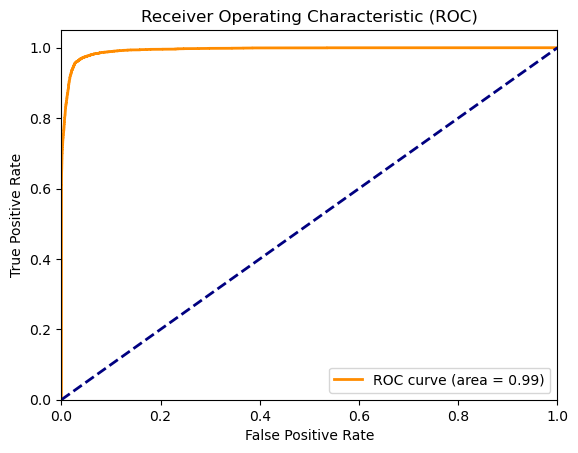

-------Test Dataset Metric-----------
Accuracy: 0.9421
Precision: 0.7956
Recall: 0.5870


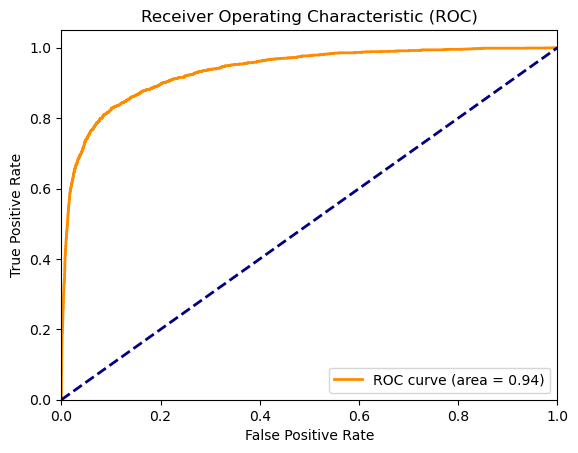

In [279]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [25, 50, 75, 100],  # Number of trees in the forest
    'max_depth': [5,8,10,15],     # The maximum depth of the tree
    # 'min_samples_split': [2, 3, 4, 5],  # The minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 3, 4, 5],  # The minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],    # Default=True. If False, the whole dataset is used to build each tree, else a sample size as specified in max_samples
    # 'max_samples' : [0.4]   # If bootstrap is True, the number/ portion of samples to draw from X to train each base estimator. Default is entire sample
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters: ", grid_search.best_params_)

best_rf = grid_search.best_estimator_

# Evaluate the best model on the test data

y_train_pred_rf = best_rf.predict(X_train)
y_train_proba_rf = best_rf.predict_proba(X_train)[:, 1]

y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)[:, 1]


show_overall_matric(y_train, y_train_pred_rf, y_train_proba_rf, y_test, y_test_pred_rf, y_test_proba_rf)

In [280]:
#Feature importance using Random Forest
feature_imp_dataset(best_rf, X_train.columns).head(10)

,Feature,Importance
0,total_ic_mou_8,0.1696
1,total_og_mou_8,0.0996
2,arpu_8,0.0587
3,avg_perc_change_in_arpu,0.0486
4,offnet_mou_8,0.0443
5,max_rech_amt_8,0.0432
6,onnet_mou_8,0.0302
7,total_rech_amt_8,0.0284
8,total_ic_mou_7,0.0281
9,ic_mou_std,0.0243


In [281]:
# Prepare data for submission file
unseen_pred = best_rf.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_randomforest.csv', df_unseen_scaled, unseen_pred)

### 6.3 Build AdaBoost Model

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ahul/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

Best parameters: {'estimator__max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 50}
-------Trainig Dataset Metric-----------
Accuracy: 0.9440
Precision: 0.7816
Recall: 0.6233


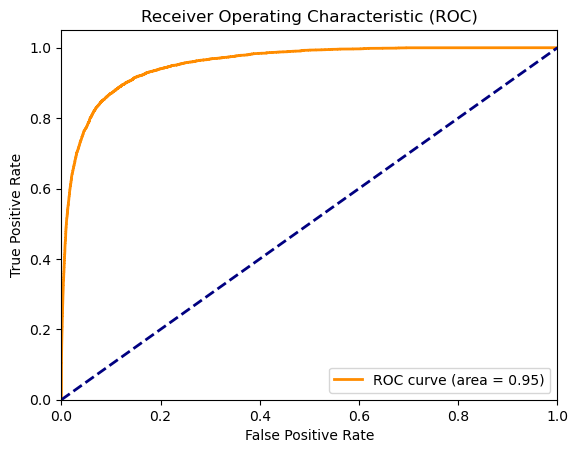

-------Test Dataset Metric-----------
Accuracy: 0.9419
Precision: 0.7690
Recall: 0.6195


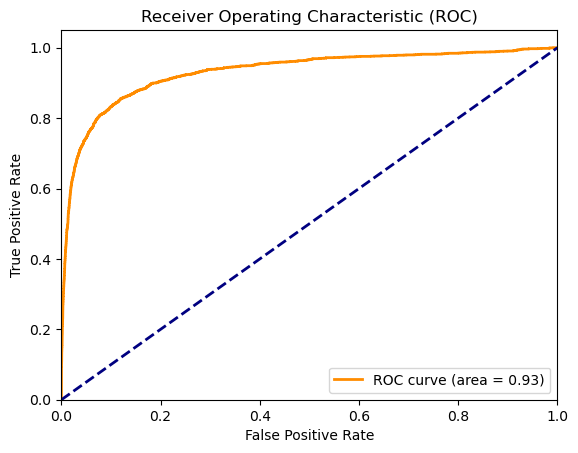

In [282]:
# Initialize a base estimator for AdaBoost 
base_estimator = DecisionTreeClassifier(max_depth=1)  # Default weak learner for AdaBoost

# Initialize AdaBoost classifier
ada_model = AdaBoostClassifier(estimator=base_estimator)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 75],  
    'learning_rate': [0.01, 0.1, 1], 
    'estimator__max_depth': [4,7,9] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Get the best estimator (model) from the grid search
best_ada = grid_search.best_estimator_

# Evaluate the best model on the test data
y_train_pred = best_ada.predict(X_train)
y_train_proba = best_ada.predict_proba(X_train)[:, 1]

y_test_pred = best_ada.predict(X_test)
y_test_proba = best_ada.predict_proba(X_test)[:, 1]


show_overall_matric(y_train, y_train_pred, y_train_proba, y_test, y_test_pred, y_test_proba)

In [283]:
# Feature Importance using AdaBoost
feature_imp_dataset(best_ada, X_train.columns).head(50)

,Feature,Importance
0,total_ic_mou_8,0.2955
1,days_since_last_recharge,0.0693
2,most_recent_rch_amt,0.0588
3,total_ic_mou_7,0.0501
4,aon,0.0483
5,ic_mou_std,0.0464
6,og_mou_std,0.0324
7,arpu_7,0.0320
8,total_og_mou_8,0.0286
9,vol_3g_mb_8,0.0281


In [284]:
# Prepare data for submission file
unseen_pred = best_ada.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_adaboost.csv', df_unseen_scaled, unseen_pred)

### 6.4 Build Gradient Boost Model

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 25}
-------Trainig Dataset Metric-----------
Accuracy: 0.9434
Precision: 0.7812
Recall: 0.6148


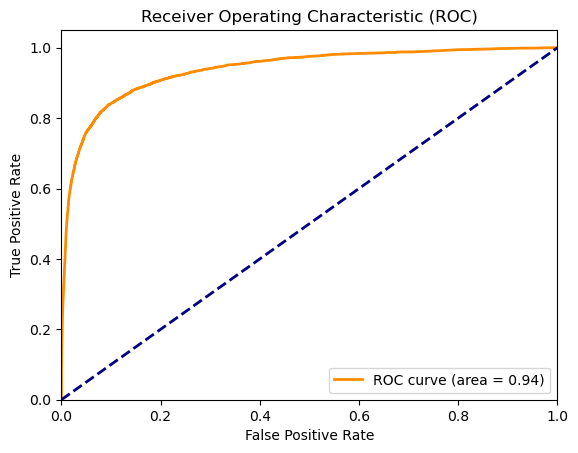

-------Test Dataset Metric-----------
Accuracy: 0.9420
Precision: 0.7727
Recall: 0.6153


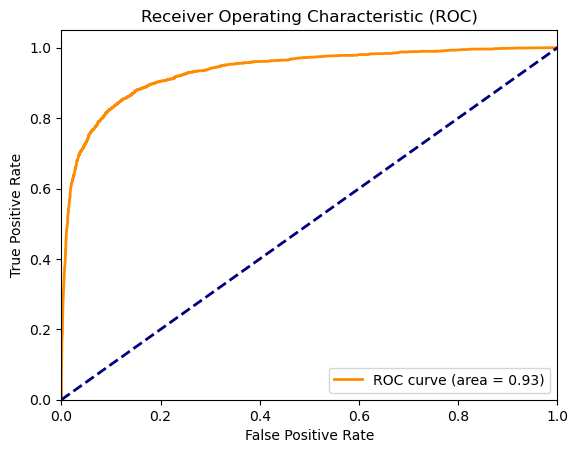

In [285]:
# Initialize Gradient Boosting classifier
gb_model = GradientBoostingClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 75],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 1],  # Step size shrinkage
    'max_depth': [4,7,9]  # Maximum depth of the individual estimators
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Get the best estimator (model) from the grid search
best_gb = grid_search.best_estimator_

# Evaluate the best model on the test data
y_train_pred = best_gb.predict(X_train)
y_train_proba = best_gb.predict_proba(X_train)[:, 1]

y_test_pred = best_gb.predict(X_test)
y_test_proba = best_gb.predict_proba(X_test)[:, 1]


show_overall_matric(y_train, y_train_pred, y_train_proba, y_test, y_test_pred, y_test_proba)

In [286]:
# Feature importance using GradientBoost
feature_imp_dataset(best_gb, X_train.columns).head(50)

,Feature,Importance
0,total_ic_mou_8,0.8116
1,vol_2g_mb_8,0.0264
2,most_recent_rch_amt,0.0207
3,arpu_8,0.0167
4,days_since_last_recharge,0.0159
5,vol_3g_mb_8,0.0152
6,total_rech_num_7,0.0130
7,total_ic_mou_7,0.0120
8,og_mou_std,0.0104
9,total_rech_num_8,0.0070


In [294]:
# Prepare data for submission file
unseen_pred = best_gb.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_gradientboost_11.csv', df_unseen_scaled, unseen_pred)

### 6.5 Build Logistic Regression Model

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
-------Trainig Dataset Metric-----------
Accuracy: 0.8310
Precision: 0.8135
Recall: 0.8590


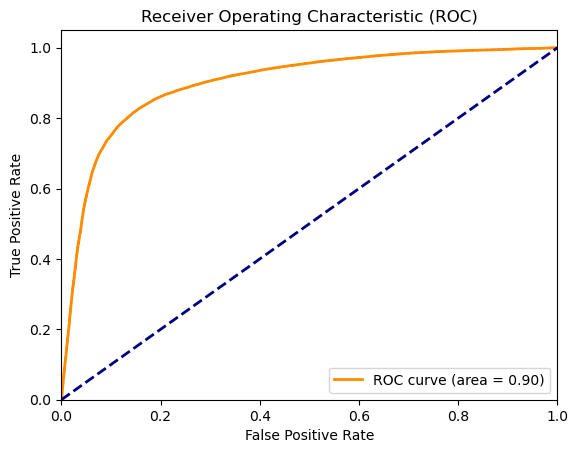

-------Test Dataset Metric-----------
Accuracy: 0.8090
Precision: 0.3314
Recall: 0.8459


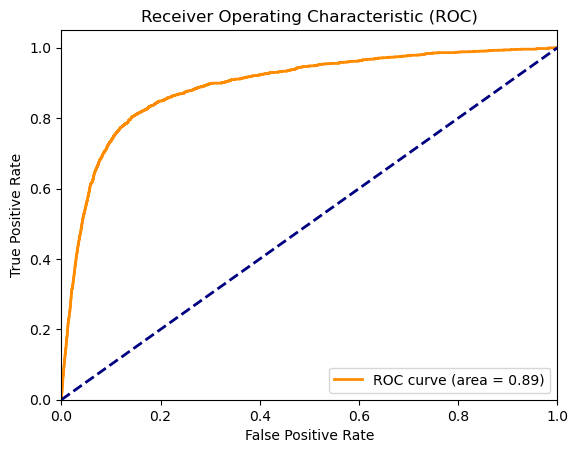

In [288]:
# Initialize Logistic Regression classifier with SMOTE data set
lr_model = LogisticRegression(max_iter=1000)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_smtd, y_train_smtd)

# Output the best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Get the best estimator (model) from the grid search
best_lr = grid_search.best_estimator_


y_train_pred = best_lr.predict(X_train_smtd)
y_train_proba = best_lr.predict_proba(X_train_smtd)[:, 1]

y_test_pred = best_lr.predict(X_test)
y_test_proba = best_lr.predict_proba(X_test)[:, 1]


show_overall_matric(y_train_smtd, y_train_pred, y_train_proba, y_test, y_test_pred, y_test_proba)

In [289]:
# Prepare data for submission file
# unseen_pred = best_lr.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_logregression.csv', df_unseen_scaled, unseen_pred)

### 6.6 Build Logistic Regression Model with PCA Data

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
-------Trainig Dataset Metric-----------
Accuracy: 0.8140
Precision: 0.7980
Recall: 0.8407


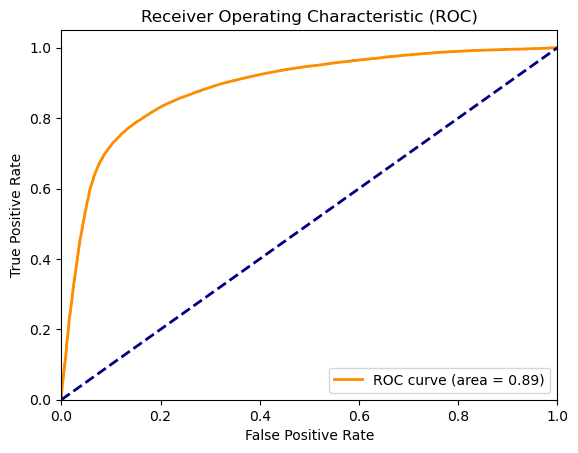

-------Test Dataset Metric-----------
Accuracy: 0.7948
Precision: 0.3111
Recall: 0.8227


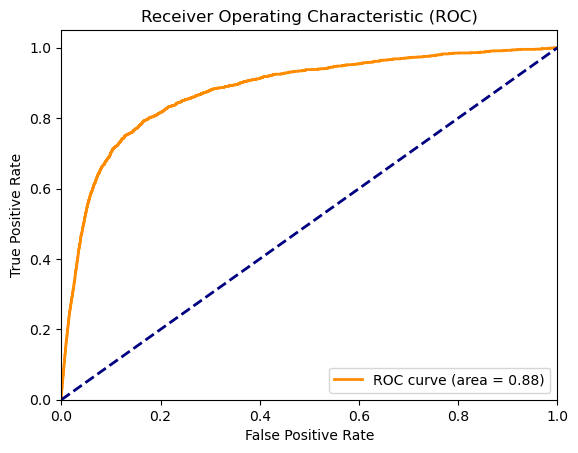

In [290]:
# Initialize Gradient Boosting classifier
lr_model = LogisticRegression(max_iter=1000)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Number of Principal Components to use
# n_components = 50

# Fit GridSearchCV on the training data
# grid_search.fit(X_train_PC[:,:n_components], y_train)
grid_search.fit(X_train_PC, y_train_smtd)

# Output the best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Get the best estimator (model) from the grid search
best_lr_pca = grid_search.best_estimator_


y_train_pred = best_lr_pca.predict(X_train_PC)
y_train_proba = best_lr_pca.predict_proba(X_train_PC)[:, 1]

y_test_pred = best_lr_pca.predict(X_test_PC)
y_test_proba = best_lr_pca.predict_proba(X_test_PC)[:, 1]


show_overall_matric(y_train_smtd, y_train_pred, y_train_proba, y_test, y_test_pred, y_test_proba)

In [297]:
# Prepare data for submission file
# unseen_pred = best_lr_pca.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_logregression_pca.csv', df_unseen_scaled, unseen_pred)

### 6.7 Build Decision Tree Model with Bagging

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:  {'bootstrap': True, 'estimator__max_depth': 5, 'max_samples': 0.8, 'n_estimators': 10}
-------Trainig Dataset Metric-----------
Accuracy: 0.9426
Precision: 0.7759
Recall: 0.6114


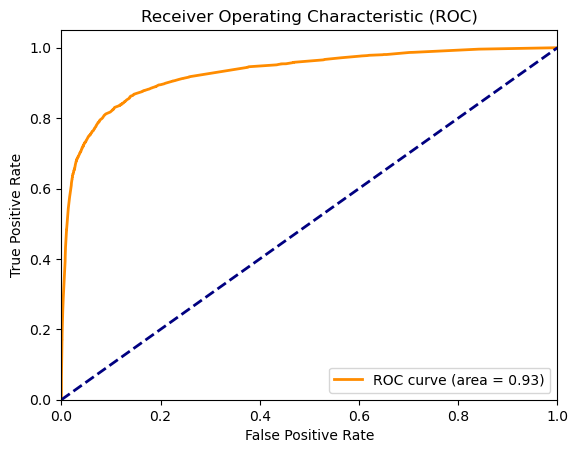

-------Test Dataset Metric-----------
Accuracy: 0.9420
Precision: 0.7703
Recall: 0.6195


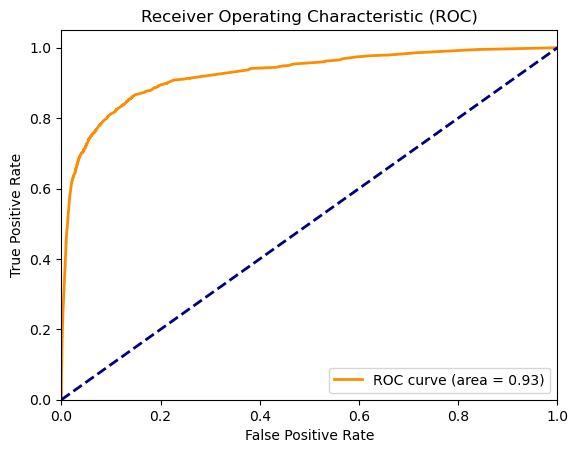

In [299]:
# Define the base model
dt_base = DecisionTreeClassifier(max_depth=15)

# Create a BaggingClassifier with RandomForest as base estimator
bagging_model = BaggingClassifier(estimator=dt_base, n_estimators=10)  # Adjust n_estimators as needed

# Define hyperparameters to tune
param_grid = {
 'bootstrap': [True, False],
 # 'bootstrap_features': [True, False],    
 'n_estimators': [5, 10, 15],                         # Number of bagging iterations
 'max_samples' : [0.6, 0.8, 1.0],                     # Portion of samples to be used in each iteration
 # 'base_estimator__bootstrap': [True, False],    
 #'base_estimator__n_estimators': [25, 50, 75, 100],  # Number of trees in the Random Forest
 # 'base_estimator__max_features' : [0.6, 0.8, 1.0],  # Number/ proportion of random features to consider for each iteration
 'estimator__max_depth': [5,10,15, 20],          # Maximum depth of trees in the Random Forest
}

grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters: ", grid_search.best_params_)

best_bag = grid_search.best_estimator_

# Evaluate the best model on the test data

y_train_pred_bag = best_bag.predict(X_train)
y_train_proba_bag = best_bag.predict_proba(X_train)[:, 1]

y_test_pred_bag = best_bag.predict(X_test)
y_test_proba_bag = best_bag.predict_proba(X_test)[:, 1]


show_overall_matric(y_train, y_train_pred_bag, y_train_proba_bag, y_test, y_test_pred_bag, y_test_proba_bag)

In [ ]:
# Feature importance using Bagging Model
feature_imp_dataset(best_bag, X_train.columns).head(50)

In [ ]:
# Prepare data for submission file
# unseen_pred = best_bag.predict(df_unseen_scaled)
# create_test_sample_data_file('./sample_baggingclf.csv', df_unseen_scaled, unseen_pred)

## 7. Select Model and Make Predictions

In [ ]:
# Create a function to write the submission file to disk
def create_test_sample_data_file(file_name, df_test_data, y_pred):
    df = pd.DataFrame({
        'id' : df_test_data.index,
        'churn_probability' : y_pred
    })
    df.to_csv(file_name, index=False)

In [302]:
# Write the submission file to disk
create_test_sample_data_file('Submission.csv', df_unseen_scaled, unseen_pred)

## 8. Conclusion

As part of this exercise, we have created following Classifier models to arrive at a suitable model to predict churn among telecom customers:
- Random Forest
- Bagging Classifier
- Adaptive Boost
- Gradient Boost
- Logistic Regression

Target metric used for model selection was primarily **Recall** score. For telecom industry, customer retention is very important and hence the model should accurately predict all potentially churning customers even if that means some non-churning customers are also tagged as churning customer. Hence the focus of the model should be to reduce false negatives (miss classification of the churn customers) as much as possible. A high Recall score indicates less false negative and hence the most appropriate metric for the problem at hand. 

Among the above models, the one that gives better consistent result is **Gradient Boosting** ensemble model. We achieved a high model accuracy of greater than 90% with a precision of over 75% and recall score of close to 65%. This model is more consistent with training and test dataset. Even though the Logistic regression model, after addressing the imbalance in the dataset, improved the Recall score, but there was significant disparity between the precision and recall values. Hence, we selected the Gradient Boost model over Logistic Regression keeping the long-term stability of the model in mind.

##### 8.1 Important features affecting the churn rate 

Churn probability is mainly characterized by customers arpu, recharge amount, incoming/ outgoing minutes usage, and 3g/2g data volume in the month of August. Top 10  direct/ derived features affecting the churn probability are give below:

- total_ic_mou_8
- vol_2g_mb_8
- most_recent_rch_amt (its derived feature based on the recharge amount)
- arpu_8
- days_since_last_recharge (its derived feature from last recharge date)
- vol_3g_mb_8
- total_rech_num_7
- total_ic_mou_7
- og_mou_std (standard deviation of outgoing MOU across three months is a derived feature)
- total_rech_num_8
- ic_mou_std (its a derived feature based on incoming mou for 3 months)



##### 8.2 Strategies to manage customer churn

- Churn rate of customers who is using the network for long period is low compared to customer who newly joined, so company must formulate innovative strategies to retain the newly acquired customers by giving them attractive discounts and freebies in the first 1-2 years.

- Historical data shows a clear pattern in the recharge amount and frequency of recharge and the churn rate. When company observe a decreasing trend in recharge amount of the customer, it should intimate the user about attractive offers based on the customer usage to increase the potential of customer’s retention within the network.

- Getting customers to use more data is a good way to hook him for long term. Hence any reduction in usage of data volume should be viewed urgently. Customer should be given offers to use more entertainment/ OTT channels which typically consume more data.

Overall, this exercise has determined important factors that are symptoms of churning customer. The Gradient Boost model should be recalibrated from time to time with more recent data to keep it current and effective.
